In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
# mpl.rcParams["image.dpi"] = 200
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import mplhep as hep
plt.style.use(hep.style.CMS)
#from plotting_utils import *
import uproot
import awkward as ak
#import dask.dataframe as dd
#from dask.distributed import Client

#client = Client(dashboard=True)

In [2]:
input_folder = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/reco_comparison/overlapping_objects_studies/electrons_genmatching"
output_folder = "plots/electrons_gen_matching_v2"
os.makedirs(output_folder, exist_ok=True)
df_1 = pd.read_hdf(f"{input_folder}/DeepSC_algoA_126X_mcRun3_2023_overlapping_v1.hdf5", "df", start=0, stop=965985)
df_1.rename(columns={"output_object.csv":"genpart_index"}, inplace=True)

In [3]:
df_2 = pd.read_hdf(f"{input_folder}/Mustache_126X_mcRun3_2023_overlapping_v1.hdf5", start=0, stop=965985)
df_2.rename(columns={"output_object.csv":"genpart_index"}, inplace=True)
df_1 = df_1.iloc[:-1]
df_2 = df_2.iloc[:-1]

In [4]:
df_1.elematched = df_1.deltaR_genPart_ele < 0.7
df_2.elematched = df_2.deltaR_genPart_ele < 0.7
#dfj = df_1.merge(df_2, on=["runId","eventId","genpart_index"], suffixes=["_D", "_M"],indicator=True, how="inner", sort=False)


In [5]:
print(df_2.head(30))

    genpart_index  elematched  phomatched  ele_index  pho_index  \
0             0.0        True         1.0        6.0        6.0   
1             1.0        True         1.0        3.0        3.0   
2             2.0        True         1.0        5.0        5.0   
3             3.0        True         1.0        0.0        0.0   
4             4.0        True         1.0        7.0        4.0   
5             5.0        True         1.0        4.0        4.0   
6             6.0        True         1.0        1.0        1.0   
7             7.0        True         1.0        2.0        2.0   
8             0.0        True         1.0        4.0        4.0   
9             1.0        True         1.0        4.0        4.0   
10            2.0        True         1.0        0.0        0.0   
11            3.0        True         1.0        2.0        2.0   
12            4.0        True         1.0        5.0        5.0   
13            5.0        True         1.0        3.0        3.

In [6]:
def calculate_deltaR(group):
    # Extract relevant columns
    group = group.sort_values(by='genpart_index')
    #print(group[['genpart_index','genpart_eta','genpart_phi']])
    eta = group['genpart_eta'].values
    phi = group['genpart_phi'].values
    et_gen = group['genpart_et'].values
    ele_et=group['ele_et'].values
    ele_index = group['ele_index'].values
    elematched = group['elematched'].values
    ele_nclsRefinedSC= group['ele_nclsRefinedSC'].values
    
    # Calculate differences and means
    eta_diff = eta[::2] - eta[1::2]
    dphi = (phi[::2] - phi[1::2])
    dphi[dphi > np.pi] -= 2 * np.pi
    dphi[dphi < -np.pi] += 2 * np.pi
    dr_diff = np.sqrt(eta_diff**2 + dphi**2)
    eta_mean = (eta[::2] + eta[1::2]) / 2
    phi_mean = (phi[::2] + phi[1::2]) / 2
    
    data = {
        'deltaR': dr_diff,
        'deltaEta':abs(eta_diff),
        'deltaPhi':abs(dphi),
        'eta_mean': eta_mean,
        'phi_mean': phi_mean,
        "calo_energy1": et_gen[::2],
        'calo_energy2': et_gen[1::2],
        'ele_et1':ele_et[::2],
        'ele_et2':ele_et[1::2],
        'ele_index1': ele_index[::2],
        'ele_index2': ele_index[1::2],
        'ele_matched1': elematched[::2],
        'ele_matched2': elematched[1::2],
        'ele_nclsRefinedSC1': ele_nclsRefinedSC[::2],
        'ele_nclsRefinedSC2': ele_nclsRefinedSC[1::2],
    }
    
    return pd.DataFrame(data)

grouped_deltas2 = df_2.groupby(['runId', 'eventId']).apply(calculate_deltaR)
grouped_deltas2.to_csv('grouped_deltas2.csv', index=True)
grouped_deltas1 = df_1.groupby(['runId', 'eventId']).apply(calculate_deltaR)
grouped_deltas1.to_csv('grouped_deltas1.csv', index=True)

In [7]:
dfj = grouped_deltas1.merge(grouped_deltas2, on=["runId","eventId"], suffixes=["_D", "_M"],indicator=True, how="inner", sort=False)
dfj.to_csv('dfj.csv', index=True)
print(dfj.columns)

Index(['deltaR_D', 'deltaEta_D', 'deltaPhi_D', 'eta_mean_D', 'phi_mean_D',
       'calo_energy1_D', 'calo_energy2_D', 'ele_et1_D', 'ele_et2_D',
       'ele_index1_D', 'ele_index2_D', 'ele_matched1_D', 'ele_matched2_D',
       'ele_nclsRefinedSC1_D', 'ele_nclsRefinedSC2_D', 'deltaR_M',
       'deltaEta_M', 'deltaPhi_M', 'eta_mean_M', 'phi_mean_M',
       'calo_energy1_M', 'calo_energy2_M', 'ele_et1_M', 'ele_et2_M',
       'ele_index1_M', 'ele_index2_M', 'ele_matched1_M', 'ele_matched2_M',
       'ele_nclsRefinedSC1_M', 'ele_nclsRefinedSC2_M', '_merge'],
      dtype='object')


# Event same ele_index

In [8]:
grouped_deltas2 = pd.read_csv('grouped_deltas2.csv')
grouped_deltas1 = pd.read_csv('grouped_deltas1.csv')
dfj =pd.read_csv('dfj.csv')
print(dfj.columns)

Index(['runId', 'eventId', 'deltaR_D', 'deltaEta_D', 'deltaPhi_D',
       'eta_mean_D', 'phi_mean_D', 'calo_energy1_D', 'calo_energy2_D',
       'ele_et1_D', 'ele_et2_D', 'ele_index1_D', 'ele_index2_D',
       'ele_matched1_D', 'ele_matched2_D', 'ele_nclsRefinedSC1_D',
       'ele_nclsRefinedSC2_D', 'deltaR_M', 'deltaEta_M', 'deltaPhi_M',
       'eta_mean_M', 'phi_mean_M', 'calo_energy1_M', 'calo_energy2_M',
       'ele_et1_M', 'ele_et2_M', 'ele_index1_M', 'ele_index2_M',
       'ele_matched1_M', 'ele_matched2_M', 'ele_nclsRefinedSC1_M',
       'ele_nclsRefinedSC2_M', '_merge'],
      dtype='object')


In [9]:
grouped_deltas = pd.read_csv('grouped_deltas2.csv')
energy_ratio = grouped_deltas['calo_energy1'] / grouped_deltas['calo_energy2']
energy_ratio[grouped_deltas['calo_energy1'] < grouped_deltas['calo_energy2']] = grouped_deltas['calo_energy2'] / grouped_deltas['calo_energy1']
grouped_deltas["energy_ratio"] = energy_ratio

In [10]:
same_ele_index_mask = (grouped_deltas['ele_index1'] == grouped_deltas['ele_index2']) &(grouped_deltas.ele_matched2==True)&(grouped_deltas.ele_matched1==True)
different_ele_index_mask = (grouped_deltas['ele_index1'] != grouped_deltas['ele_index2'] )&(grouped_deltas.ele_matched2==True)&(grouped_deltas.ele_matched1==True)
same_ele_events = grouped_deltas[same_ele_index_mask]
different_ele_events = grouped_deltas[different_ele_index_mask]
onemissing_events_mask =  ( (grouped_deltas.ele_matched1==False)&(grouped_deltas.ele_matched2==True))|( (grouped_deltas.ele_matched2==False)&(grouped_deltas.ele_matched1==True))
onemissing_events = grouped_deltas[onemissing_events_mask]

print(same_ele_events)
print(onemissing_events)


         runId  eventId  Unnamed: 2    deltaR  deltaEta  deltaPhi  eta_mean  \
8          1.0      3.0           0  0.396164  0.137326  0.371601 -2.731669   
11         1.0      3.0           3  0.121039  0.077407  0.093052  2.323035   
14         1.0      4.0           2  0.408611  0.138801  0.384314  1.463442   
15         1.0      4.0           3  0.664554  0.135085  0.650680  2.216470   
20         1.0      6.0           0  0.057895  0.041387  0.040484 -1.866780   
...        ...      ...         ...       ...       ...       ...       ...   
482970  4595.0     43.0           2  0.688145  0.167500  0.667448  0.257762   
482971  4595.0     43.0           3  0.595962  0.062210  0.592706  1.513993   
482975  4595.0     44.0           3  0.419725  0.120869  0.401945  1.556691   
482980  4595.0     46.0           0  0.096985  0.081974  0.051830 -2.547373   
482984  4595.0     47.0           0  0.108707  0.089453  0.061769 -2.023988   

        phi_mean  calo_energy1  calo_energy2     el

In [23]:
print(f"% of windows with genpart1 matched to electron: {sum(grouped_deltas.ele_matched1 == True)/ len(grouped_deltas)*100:.3f}%")
print(f"% of windows with genpart2 matched to electron: {sum(grouped_deltas.ele_matched2 == True)/ len(grouped_deltas)*100:.3f}%")

% of windows with genpart1 matched to electron: 89.366%
% of windows with genpart2 matched to electron: 89.212%


In [24]:
max_energy1 = (same_ele_events['calo_energy2']).max()
min_energy1 = same_ele_events['calo_energy2'].min()

# Print the maximum and minimum values
print("Maximum energy1:", max_energy1)
print("Minimum energy1:", min_energy1)

Maximum energy1: 499.99522638961696
Minimum energy1: 1.0015861973162588


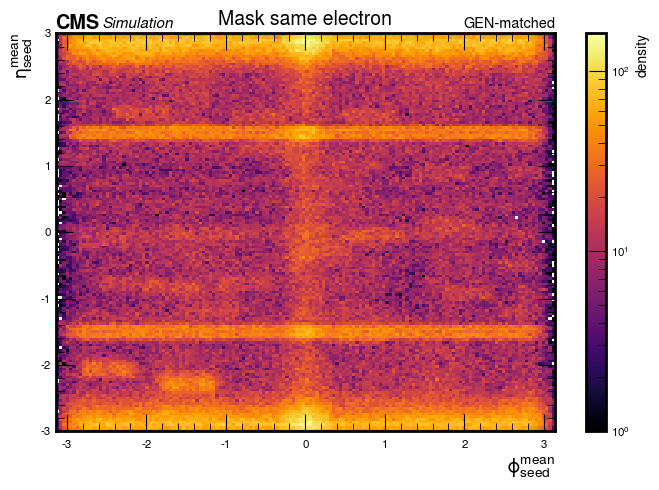

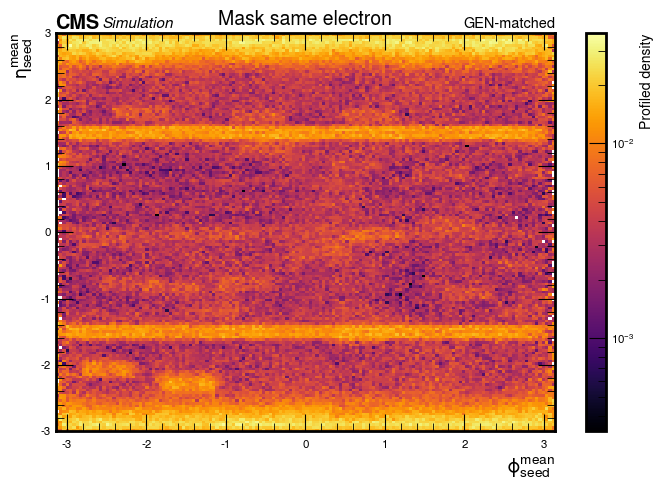

In [56]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.phi_mean ,same_ele_events.eta_mean,bins=(150, 150), range=((-np.pi,np.pi),(-3,3)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_ylabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_xlabel("$\phi^{mean}_{seed}$", fontsize=14)
plt.title('Mask same electron',fontsize=14)
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax,fontsize=11)
plt.tight_layout()
plt.savefig('plots/eta_phi.png')
plt.show()
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.phi_mean ,same_ele_events.eta_mean,bins=(150, 150), range=((-np.pi,np.pi),(-3,3)))

s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="Profiled density")
ax.set_ylabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_xlabel("$\phi^{mean}_{seed}$", fontsize=14)
plt.title('Mask same electron',fontsize=14)
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax,fontsize=11)
plt.tight_layout()
plt.savefig('plots/eta_phi_prof.png')


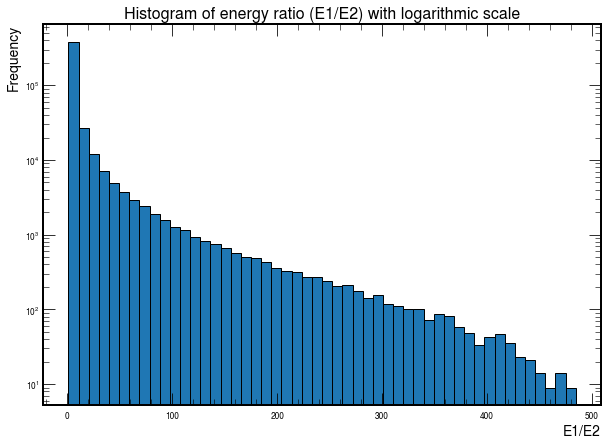

min energyratio:  1.0000001119237847


In [6]:
energy_ratio = same_ele_events['calo_energy1'] / same_ele_events['calo_energy2']
energy_ratio[same_ele_events['calo_energy1'] < same_ele_events['calo_energy2']] = same_ele_events['calo_energy2'] / same_ele_events['calo_energy1']

plt.subplots(figsize=(10,7))
plt.hist(energy_ratio, bins=50, edgecolor='black', log=True)  # Set log=True
plt.xlabel('E1/E2', fontsize=14)  # Increase fontsize for x-label
plt.ylabel('Frequency', fontsize=14)  # Increase fontsize for y-label
plt.title('Histogram of energy ratio (E1/E2) with logarithmic scale', fontsize=16)  # Increase fontsize for title
plt.savefig('plots/hist_e1-e2.png')
plt.show()
print('min energyratio: ', energy_ratio.min())

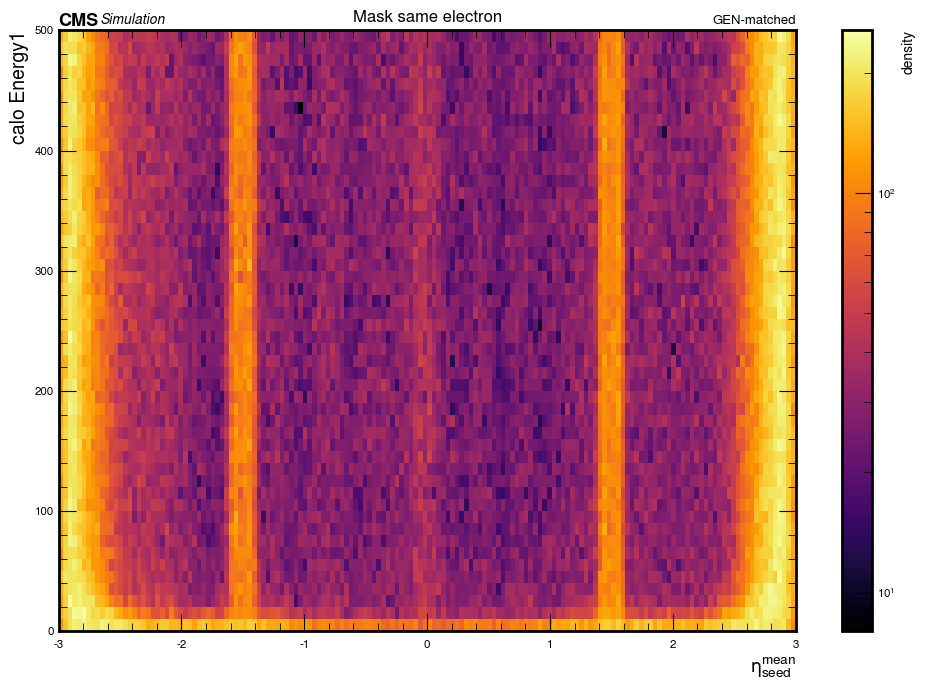

In [6]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(10, 7))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,same_ele_events.calo_energy1,bins=(160, 50), range=((-3,3),(0,500)))

s = 1 #np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("calo Energy1", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/e1_eta.png')

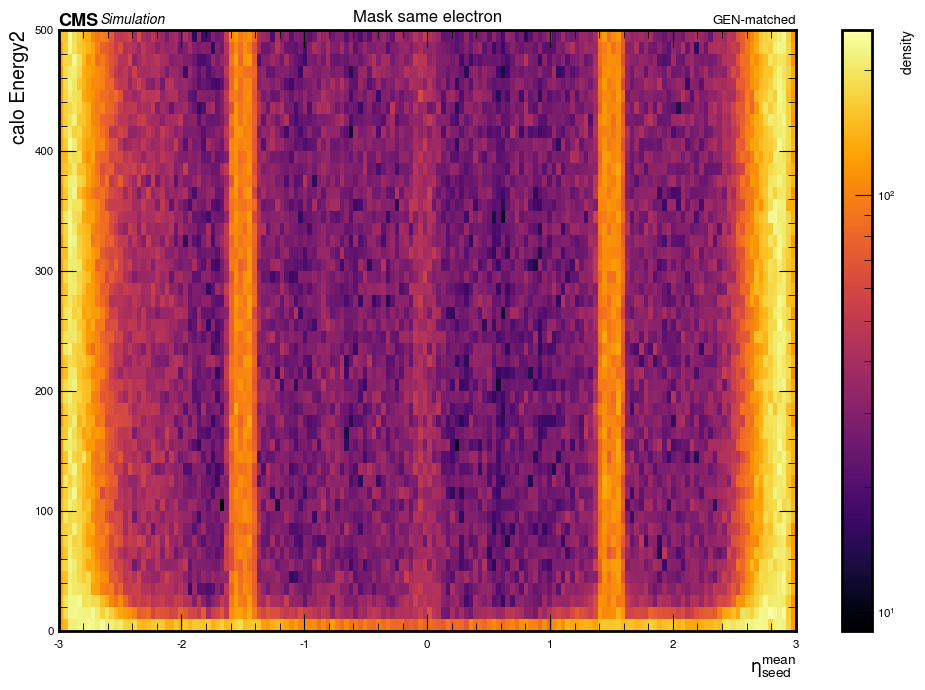

In [7]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(10, 7))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,same_ele_events.calo_energy2,bins=(160, 50), range=((-3,3),(0,500)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label=" density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("calo Energy2", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/e2_eta.png')

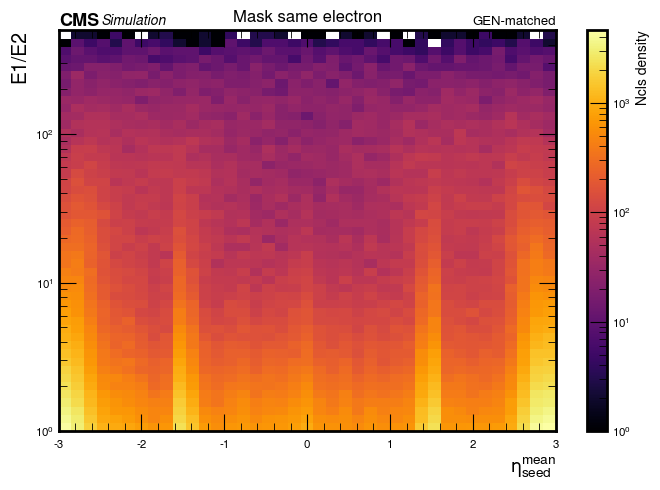

In [8]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,energy_ratio, 
                                  bins=[
                                      np.linspace(-3,3,40), np.logspace(0, np.log10(500), 50, base=10)
                                  ])

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="Ncls density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("E1/E2", fontsize=14)
plt.title('Mask same electron')
ax.set_yscale("log")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/e1-e2_eta.png')

## ele_et

In [9]:
max_energy1 = (same_ele_events['ele_et1']).max()
min_energy1 = same_ele_events['ele_et2'].min()

# Print the maximum and minimum values
print("Maximum energy1:", max_energy1)
print("Minimum energy1:", min_energy1)

Maximum energy1: 3098.338623046875
Minimum energy1: 0.0643110051751136


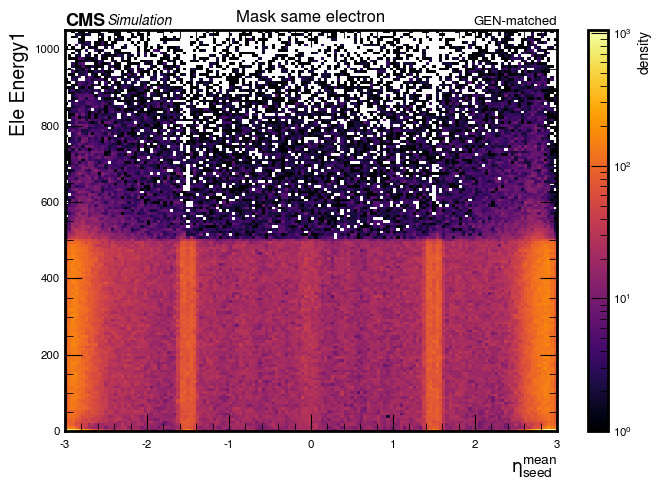

In [10]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,same_ele_events.ele_et1,bins=(150, 150), range=((-3,3),(0,1050)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("Ele Energy1", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/eleet1_eta.png')

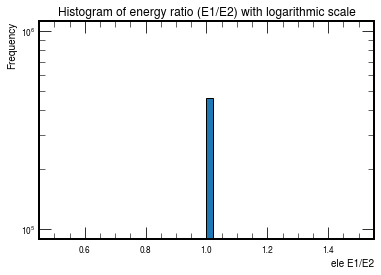

min energyratio:  1.0


'\nfig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))\n\nA,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,energy_ratio,bins=(150, 150), range=((-3,3),(0,400)))\n\ns = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)\na = A/s\nX, Y = np.meshgrid(xedges, yedges)\nI = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")\n\nfig.colorbar(I, ax=ax, label="density")\nax.set_xlabel("$\\eta^{mean}_{seed}$", fontsize=14)\nax.set_ylabel("ele E1/E2", fontsize=14)\nplt.title(\'Mask same electron\')\nhep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)\nplt.tight_layout()\nplt.savefig(\'plots/ele_e1-e2_eta.png\')\n'

In [11]:
energy_ratio = same_ele_events['ele_et1'] / same_ele_events['ele_et2']
energy_ratio[same_ele_events['ele_et1'] < same_ele_events['ele_et2']] = same_ele_events['ele_et2'] / same_ele_events['ele_et1']

plt.hist(energy_ratio, bins=50, edgecolor='black', log=True)  # Set log=True
plt.xlabel('ele E1/E2')
plt.ylabel('Frequency')
plt.title('Histogram of energy ratio (E1/E2) with logarithmic scale')
plt.savefig('plots/hist_e1-e2.png')
plt.show()
print('min energyratio: ', energy_ratio.min())
'''
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,energy_ratio,bins=(150, 150), range=((-3,3),(0,400)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("ele E1/E2", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/ele_e1-e2_eta.png')
'''

# Delta R study

In [7]:
total_events = len(grouped_deltas)

same_ele_index_events = grouped_deltas[grouped_deltas['ele_index1'] == grouped_deltas['ele_index2']]
same_ele_index_count = len(same_ele_index_events)
percentage_same_ele_index = (same_ele_index_count / total_events) * 100

print(f"Percentage of events with the same ele_index: {percentage_same_ele_index:.2f}%")

Percentage of events with the same ele_index: 23.00%


In [8]:
eta_mean_range = (1.4, 1.6)

filtered_events = grouped_deltas[(grouped_deltas['eta_mean'] >= eta_mean_range[0]) & 
                                 (grouped_deltas['eta_mean'] <= eta_mean_range[1]) &
                                 (grouped_deltas['ele_index1'] == grouped_deltas['ele_index2'])]
total_events_eta_range = len(grouped_deltas[(grouped_deltas['eta_mean'] >= eta_mean_range[0]) & 
                                             (grouped_deltas['eta_mean'] <= eta_mean_range[1])])
same_ele_eta_range_count = len(filtered_events)
percentage_same_ele_index_eta_range = (same_ele_eta_range_count / total_events_eta_range) * 100

print(f"Percentage of events with the same ele_index in the range eta {eta_mean_range}: {percentage_same_ele_index_eta_range:.2f}%")

Percentage of events with the same ele_index in the range eta (1.4, 1.6): 41.48%


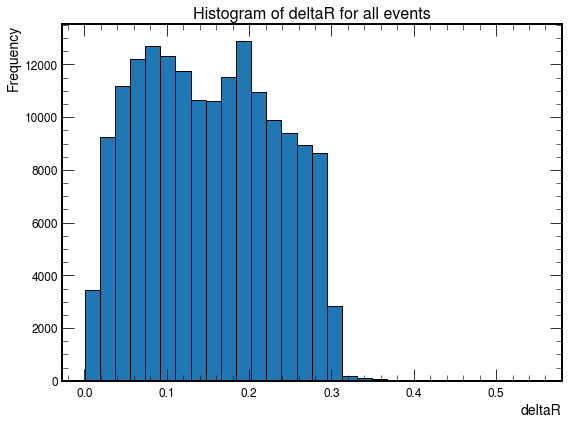

In [58]:
plt.figure(figsize=(8, 6))  
plt.hist(same_ele_events['deltaR'], bins=30, edgecolor='black')
plt.xlabel('deltaR', fontsize=14)  
plt.ylabel('Frequency', fontsize=14)  
plt.title('Histogram of deltaR for all events', fontsize=16)  
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
plt.tight_layout() 
plt.savefig('plots/deltaR_histogram.png')
plt.show()

In [59]:
print('delta r max: ',same_ele_events['deltaR'].max())

delta r max:  0.552025995111219


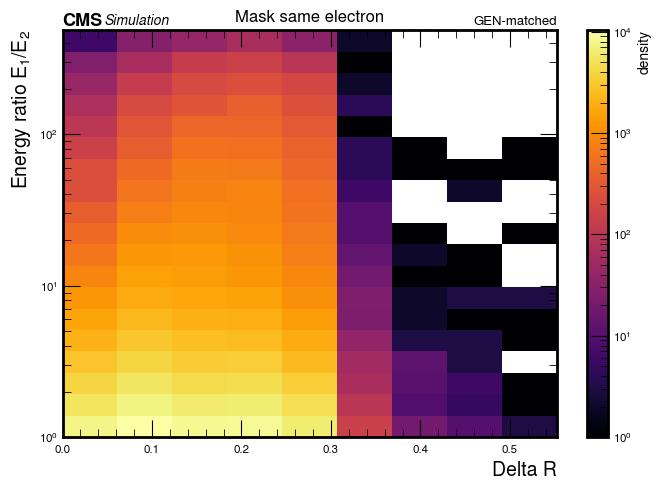

In [62]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events['deltaR'],same_ele_events['energy_ratio'],bins=[
                                      np.linspace(0,same_ele_events['deltaR'].max(),10), np.logspace(0, np.log10(energy_ratio.max()), 20, base=10)
                                  ])

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_xlabel("Delta R", fontsize=14)
ax.set_ylabel("Energy ratio $E_1/E_2$", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
ax.set_yscale("log")
plt.tight_layout()
plt.savefig('plots/deltar_energyratio.png')

## Matched to the same Electron

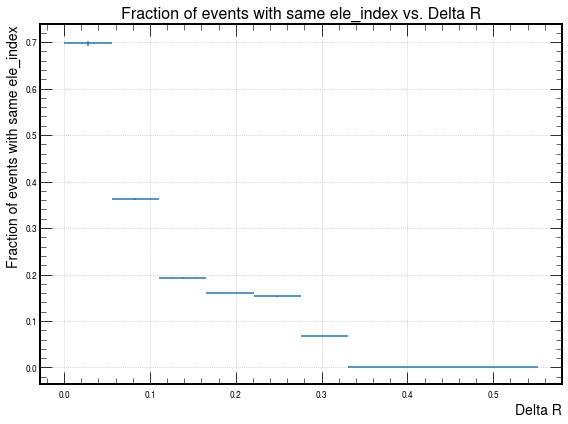

In [87]:
def fraction_same_ele_index_vs_deltaR(num_intervals):
    deltaR_max = same_ele_events['deltaR'].max()
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    fraction_list = []
    yer = []

    for i in range(len(deltaR_values) - 1):
        lower_bound = deltaR_values[i]
        upper_bound = deltaR_values[i + 1]
        #print('interval=[',lower_bound,upper_bound,']')
        mask = (same_ele_events['deltaR'] > lower_bound) & (same_ele_events['deltaR'] <= upper_bound)
        mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound)

        n1 = len(same_ele_events[mask])
        #print('n1: ',n1)
        ntot = len(grouped_deltas[mask2])
        #print('ntot: ',ntot)
        if ntot == 0:
            ntot = 1
        fraction = n1 / ntot
        fraction_list.append(fraction)
        yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)

    plt.figure(figsize=(8,6))  # Larger figsize
    plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none')
    #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('Delta R', fontsize=14)
    plt.ylabel('Fraction of events with same ele_index', fontsize=14) 
    plt.title('Fraction of events with same ele_index vs. Delta R', fontsize=16)  
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('plots/fraction_deltaR.png')
    plt.show()

num_intervals = 10
fraction_same_ele_index_vs_deltaR(num_intervals)


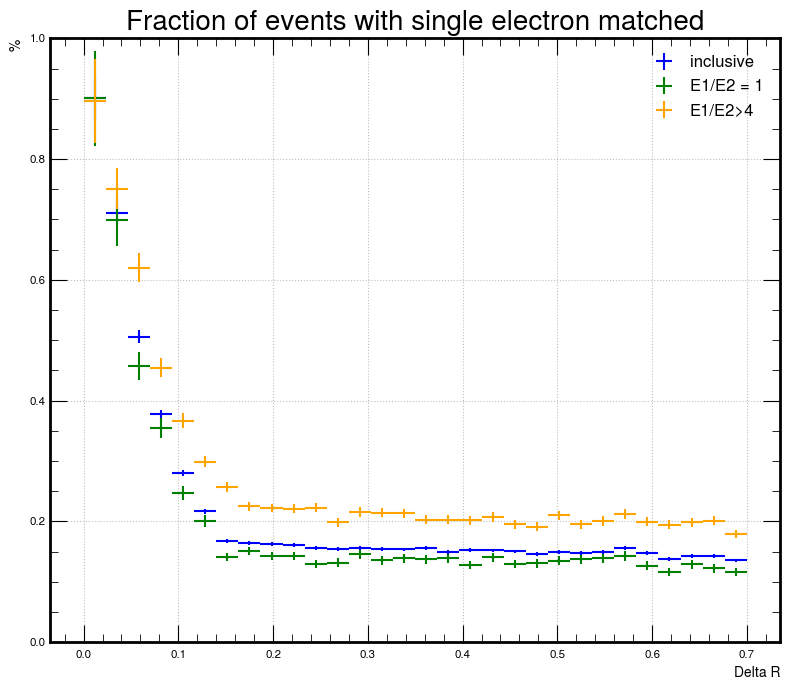

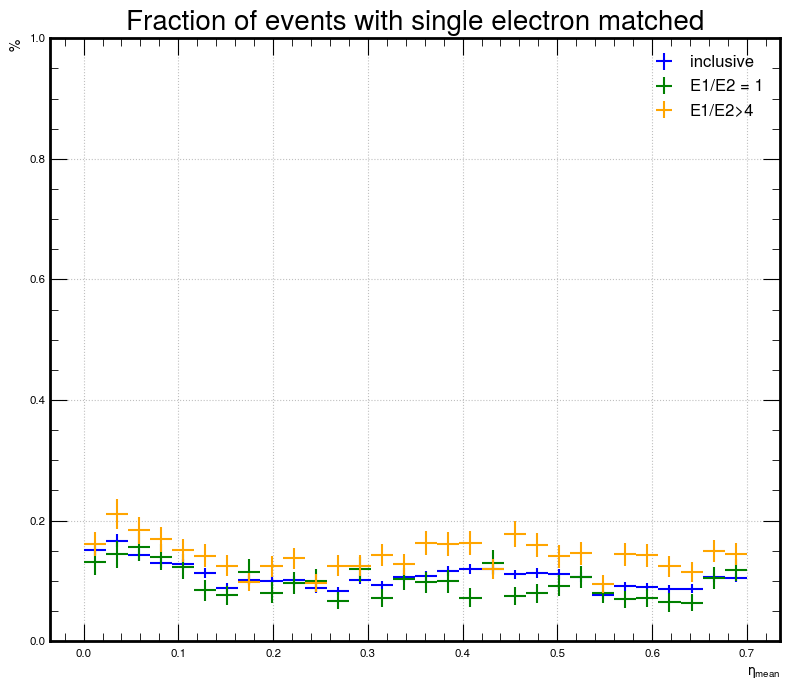

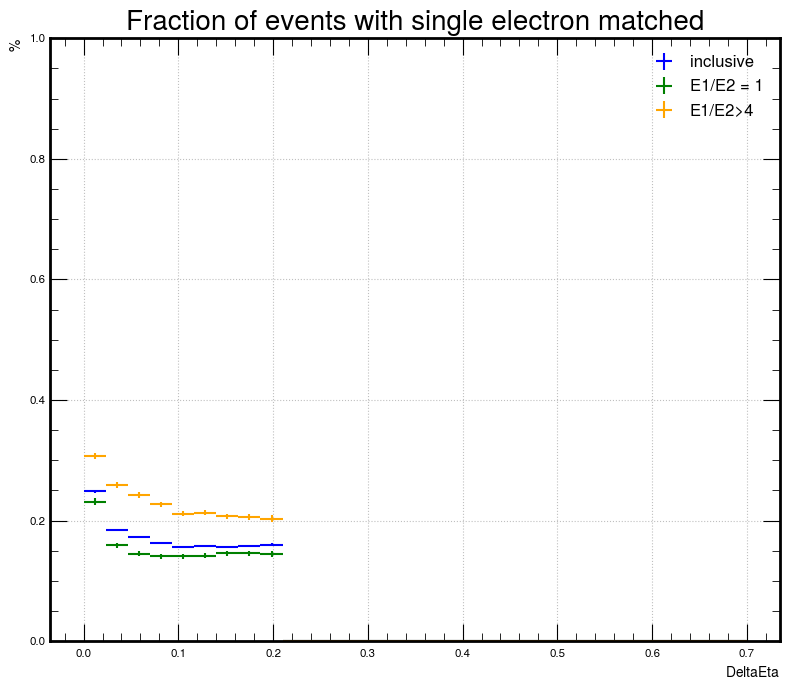

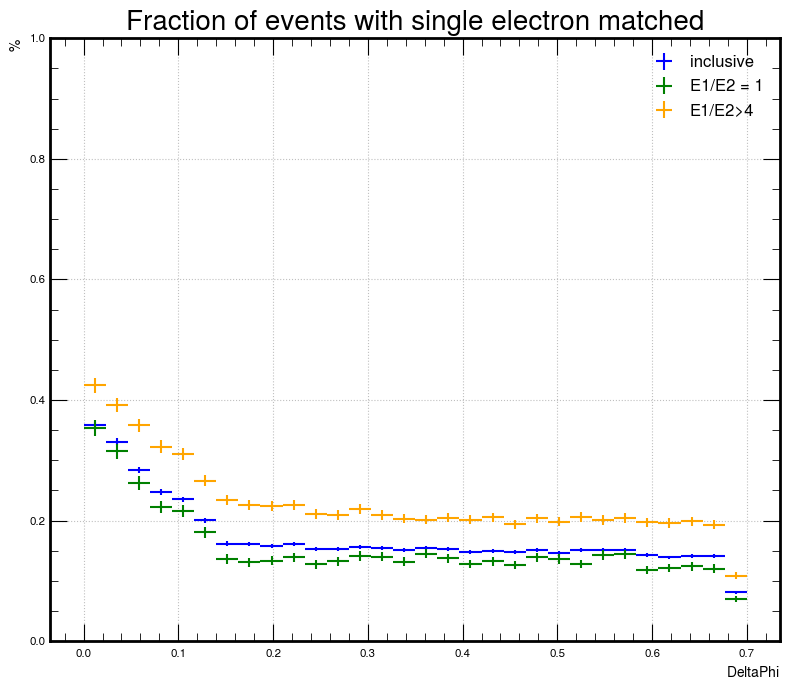

0.6997783184051509


In [18]:
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3

def fraction_same_ele_index_vs_deltaR(num_intervals,detltaR_max,col,xlab):
    deltaR_max = 0.7
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    masks = [(1,1), 
             ((same_ele_events.energy_ratio > 0.8)&(same_ele_events.energy_ratio < 1.2),
              (grouped_deltas.energy_ratio > 0.8)&(grouped_deltas.energy_ratio < 1.2)),
             ((same_ele_events.energy_ratio > 4), (grouped_deltas.energy_ratio > 4))]

    names = ["inclusive", "E1/E2 = 1", "E1/E2>4"]
    colors= ["blue", "green", "orange"]
    plt.figure(figsize=(8,7), dpi=100)  # Larger figsize
    for (mask_same, mask_all), name, color in zip(masks, names, colors):
        
        fraction_list = []
        yer = []
    
        # mask_en_same = (same_ele_events.energy_ratio > 0.8)&(same_ele_events.energy_ratio > 1.2)
        # mask_en_same2 = (same_ele_events.energy_ratio > 3)
       #for mask_en in [True, mask_en_same, mask_en_same2)
        for i in range(len(deltaR_values) - 1):
            lower_bound = deltaR_values[i]
            upper_bound = deltaR_values[i + 1]
            #print('interval=[',lower_bound,upper_bound,']')
            mask = (same_ele_events[col] > lower_bound) & (same_ele_events[col] <= upper_bound) & mask_same
            mask2 = (grouped_deltas[col] > lower_bound) & (grouped_deltas[col] <= upper_bound) & mask_all
            
    
            n1 = len(same_ele_events[mask])
            #print('n1: ',n1)
            ntot = len(grouped_deltas[mask2])
            #print('ntot: ',ntot)
            if ntot == 0:
                ntot = 1
            fraction = n1 / ntot
            fraction_list.append(fraction)
            yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)
    
       
        plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none',
                    label=name, c=color)
        #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel(xlab)
    plt.ylabel('%') 
    plt.ylim(0, 1)
    plt.title('Fraction of events with single electron matched', fontsize=20)  
    plt.grid(True)
    plt.tight_layout()
    
    plt.legend(fontsize=12)
    plt.savefig('plots/sameele_deltaR_E.png')
    plt.show()

    
    
    


    
num_intervals = 30
fraction_same_ele_index_vs_deltaR(num_intervals,0.7, 'deltaR','Delta R')
fraction_same_ele_index_vs_deltaR(num_intervals,3,'eta_mean','$\eta_{mean}$')
fraction_same_ele_index_vs_deltaR(num_intervals,0.2,'deltaEta','$Delta Eta$')
fraction_same_ele_index_vs_deltaR(num_intervals,0.7,'deltaPhi','$Delta Phi$')
print(same_ele_events['deltaPhi'].max())

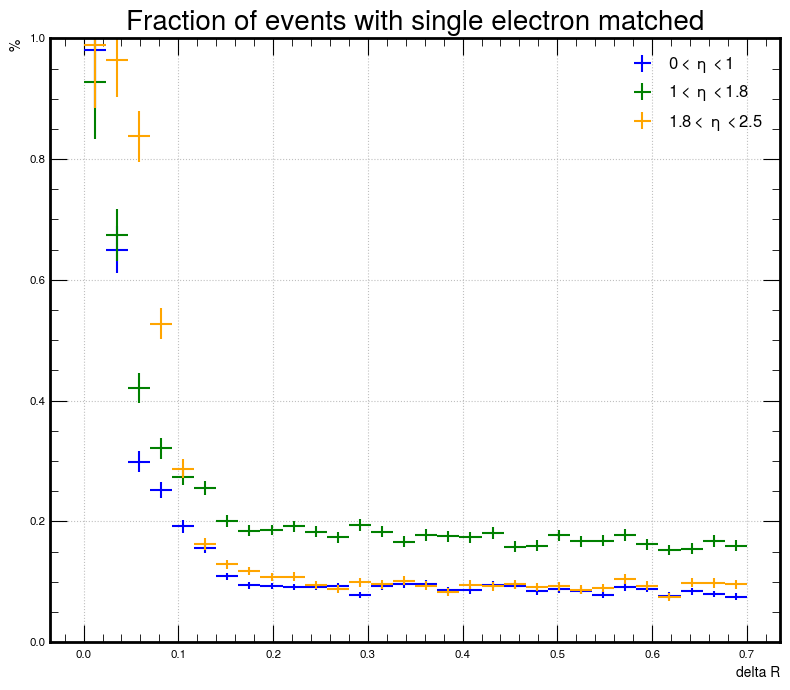

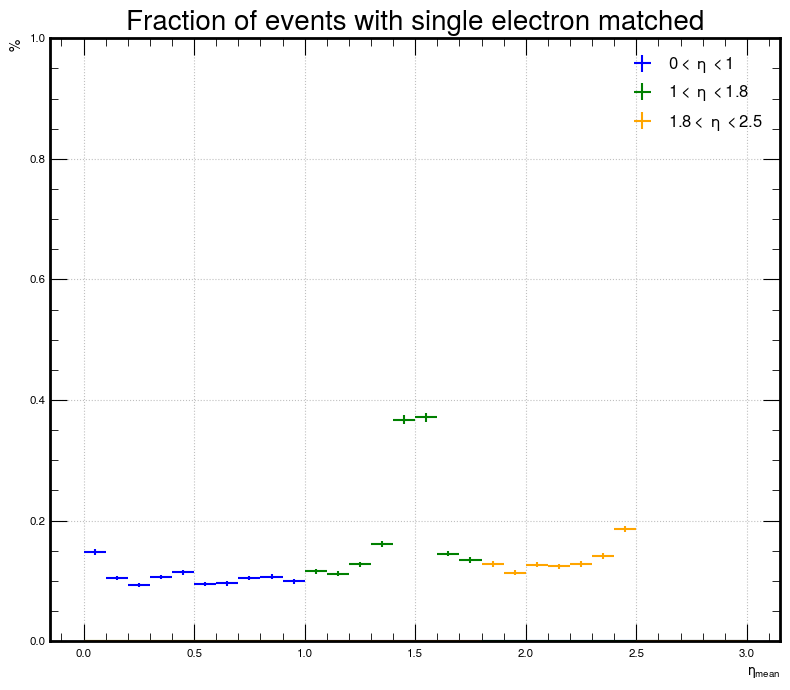

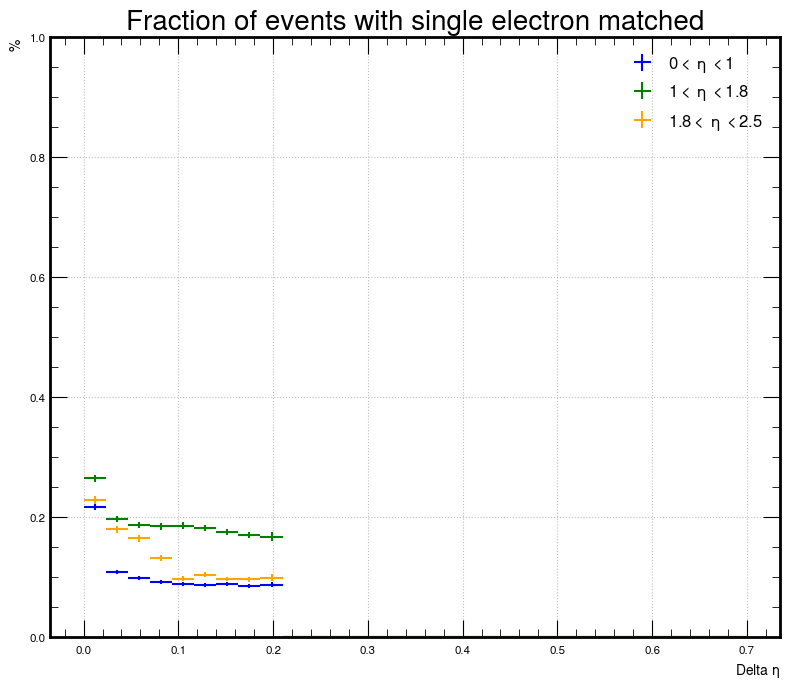

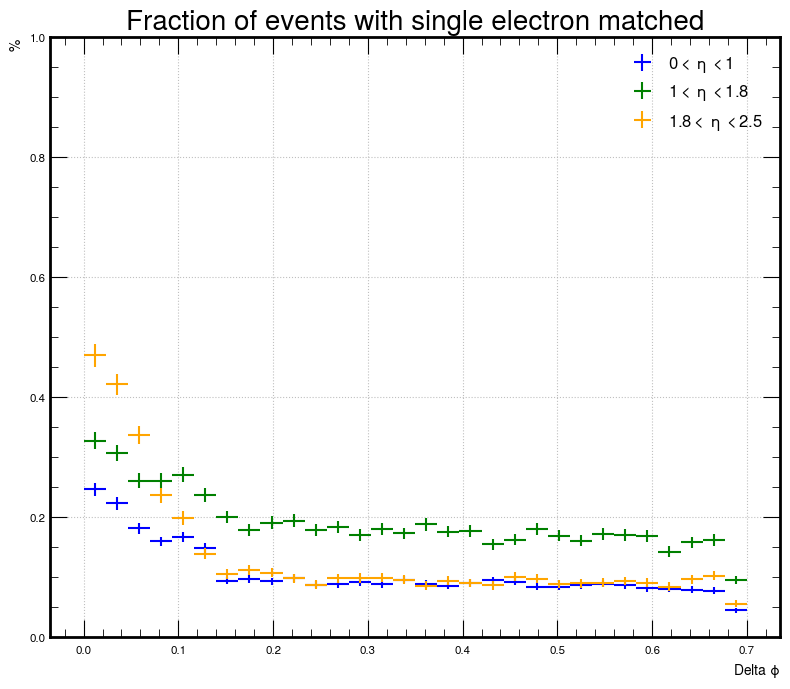

In [16]:
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3

def fraction_same_ele_index_vs_deltaR(num_intervals,deltaR_max,col , xlab):
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)
    mask_e1_g = (grouped_deltas.eta_mean<1)&(grouped_deltas.eta_mean>0)
    mask_e3_g =(grouped_deltas.eta_mean<1.8)&(grouped_deltas.eta_mean>1)
    mask_e0_g =(grouped_deltas.eta_mean<2.5)&(grouped_deltas.eta_mean>1.8)
    mask_e1 = (same_ele_events.eta_mean<1)&(same_ele_events.eta_mean>0)
    mask_e3 =(same_ele_events.eta_mean<1.8)&(same_ele_events.eta_mean>1)
    mask_e0 =(same_ele_events.eta_mean<2.5)&(same_ele_events.eta_mean>1.8)
    
    masks = [(mask_e1,mask_e1_g),
             (mask_e3,mask_e3_g),
             (mask_e0,mask_e0_g)]

    names = ['$0< \; \eta \; <1$', '$1< \; \eta \; <1.8$','$1.8< \; \eta \; <2.5$']
    colors= ["blue", "green", "orange"]
    plt.figure(figsize=(8,7), dpi=100)  # Larger figsize
    for (mask_same, mask_all), name, color in zip(masks, names, colors):
        
        fraction_list = []
        yer = []
    
        # mask_en_same = (same_ele_events.energy_ratio > 0.8)&(same_ele_events.energy_ratio > 1.2)
        # mask_en_same2 = (same_ele_events.energy_ratio > 3)
       #for mask_en in [True, mask_en_same, mask_en_same2)
        for i in range(len(deltaR_values) - 1):
            lower_bound = deltaR_values[i]
            upper_bound = deltaR_values[i + 1]
            #print('interval=[',lower_bound,upper_bound,']')
            mask = (same_ele_events[col] > lower_bound) & (same_ele_events[col] <= upper_bound) & mask_same
            mask2 = (grouped_deltas[col] > lower_bound) & (grouped_deltas[col] <= upper_bound) & mask_all
            
    
            n1 = len(same_ele_events[mask])
            #print('n1: ',n1)
            ntot = len(grouped_deltas[mask2])
            #print('ntot: ',ntot)
            if ntot == 0:
                ntot = 1
            fraction = n1 / ntot
            fraction_list.append(fraction)
            yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)
    
       
        plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none',
                    label=name, c=color)
        #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel(xlab)
    plt.ylabel('%') 
    plt.ylim(0, 1)
    plt.title('Fraction of events with single electron matched', fontsize=20)  
    plt.grid(True)
    plt.tight_layout()
    
    plt.legend(fontsize=12)
    plt.savefig('plots/sameelle_deltaR_eta.png')
    plt.show()

num_intervals = 30
fraction_same_ele_index_vs_deltaR(num_intervals,0.7,'deltaR', 'delta R')
fraction_same_ele_index_vs_deltaR(num_intervals, 3, 'eta_mean','$\eta_{mean}$')
fraction_same_ele_index_vs_deltaR(num_intervals, 0.7, 'deltaEta','Delta $\eta$')
fraction_same_ele_index_vs_deltaR(num_intervals, 0.7, 'deltaPhi','Delta $\phi$')

## matched to a different ele

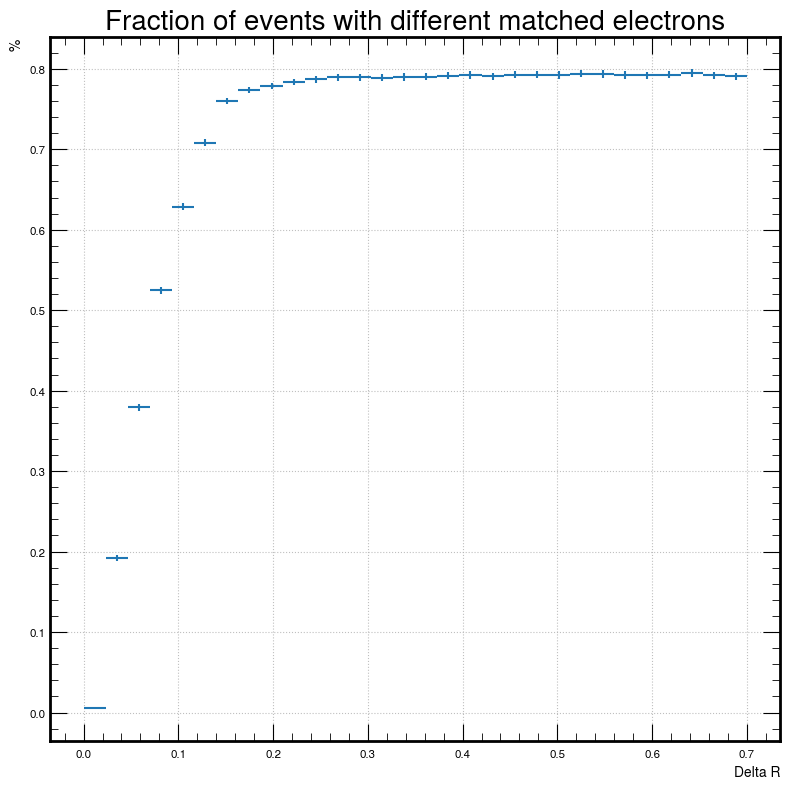

In [129]:
def fraction_onemissing_ele_index_vs_deltaR(num_intervals):
    deltaR_max = 0.7
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    fraction_list = []
    yer = []

    for i in range(len(deltaR_values) - 1):
        lower_bound = deltaR_values[i]
        upper_bound = deltaR_values[i + 1]
        #print('interval=[',lower_bound,upper_bound,']')
        mask =  (different_ele_events['deltaR'] > lower_bound) &  (different_ele_events['deltaR'] <= upper_bound)
        mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound)

        n1 = len(different_ele_events[mask])
        #print('n1: ',n1)
        ntot = len(grouped_deltas[mask2])
        #print('ntot: ',ntot)
        if ntot == 0:
            ntot = 1
        fraction = n1 / ntot
        fraction_list.append(fraction)
        yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)

    plt.figure(figsize=(8,8), dpi=100)  # Larger figsize
    plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none')
    #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('Delta R')
    plt.ylabel('%') 
    plt.title('Fraction of events with different matched electrons', fontsize=20)  
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('plots/different_ele_deltaR.png')
    plt.show()

num_intervals = 30
fraction_onemissing_ele_index_vs_deltaR(num_intervals)


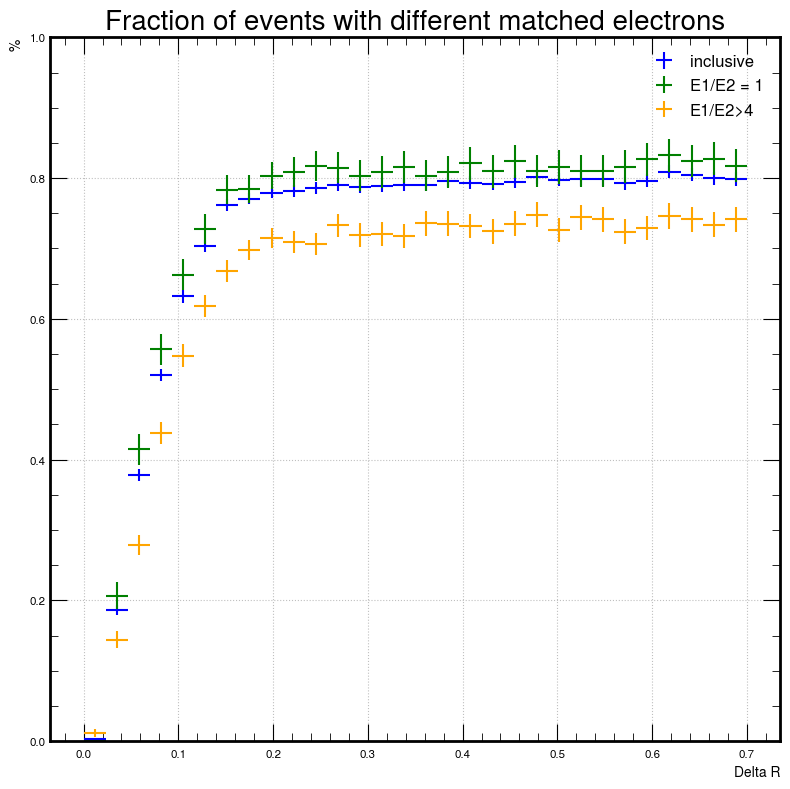

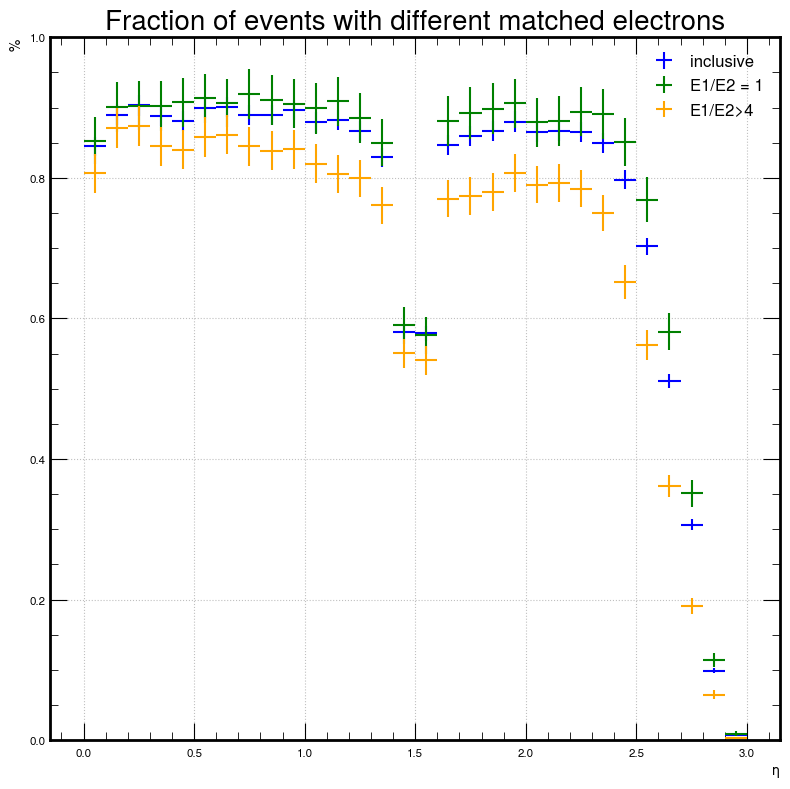

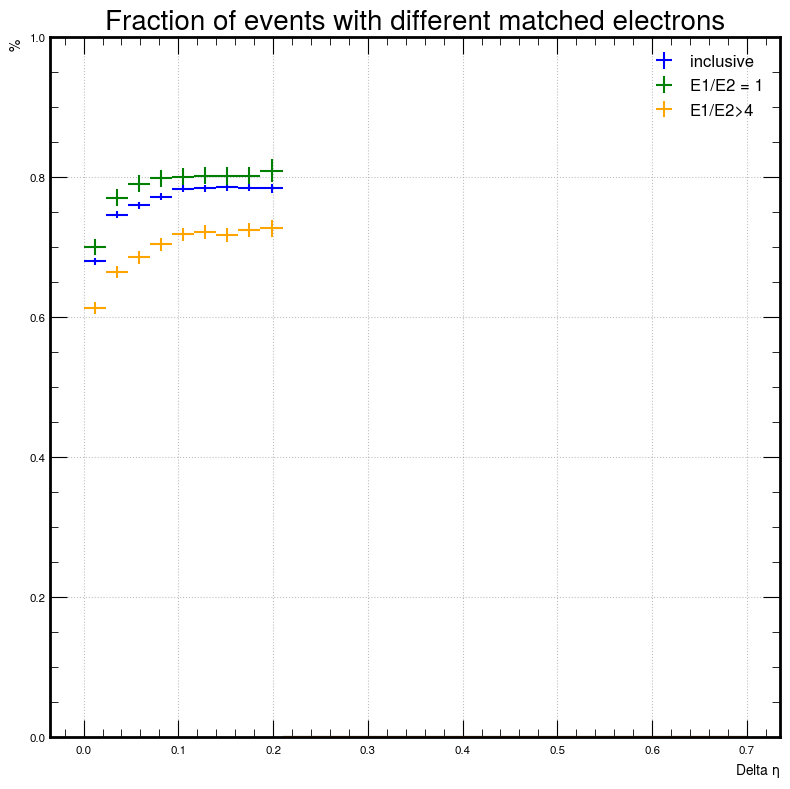

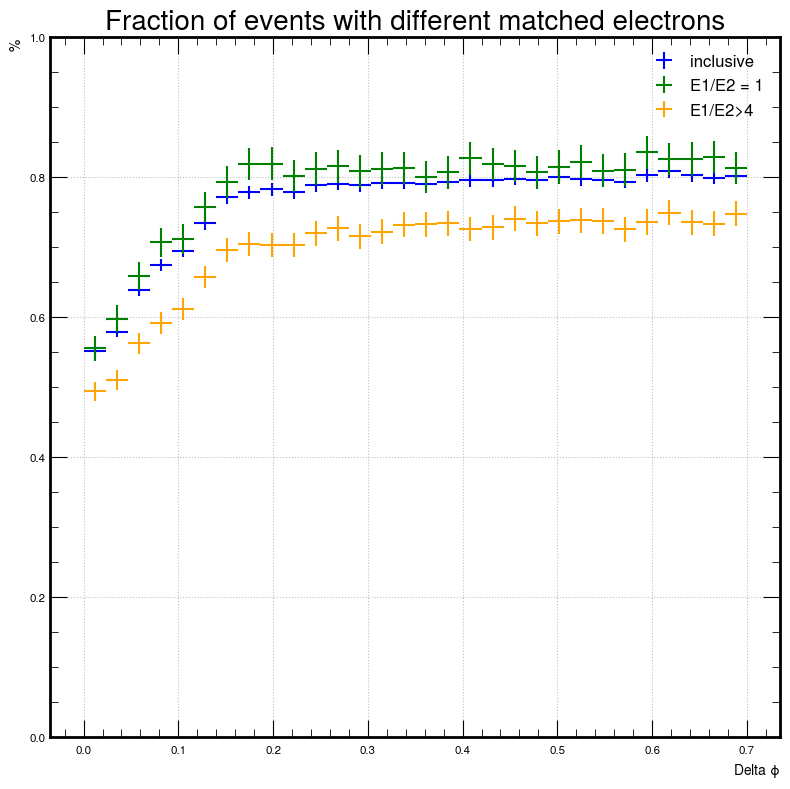

In [20]:
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3

def fraction_different_ele_index_vs_deltaR(num_intervals,different_ele_events,deltaR_max,col,xlab):
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    masks = [(1,1), 
             ((different_ele_events.energy_ratio > 0.8)&(different_ele_events.energy_ratio < 1.2),
              (grouped_deltas.energy_ratio > 0.8)&(grouped_deltas.energy_ratio < 1.2)),
             ((different_ele_events.energy_ratio > 4), (grouped_deltas.energy_ratio > 4))]

    names = ["inclusive", "E1/E2 = 1", "E1/E2>4"]
    colors= ["blue", "green", "orange"]
    plt.figure(figsize=(8,8), dpi=100)  # Larger figsize
    for (mask_same, mask_all), name, color in zip(masks, names, colors):
        
        fraction_list = []
        yer = []
    
        # mask_en_same = (different_ele_events.energy_ratio > 0.8)&(different_ele_events.energy_ratio > 1.2)
        # mask_en_same2 = (different_ele_events.energy_ratio > 3)
       #for mask_en in [True, mask_en_same, mask_en_same2)
        for i in range(len(deltaR_values) - 1):
            lower_bound = deltaR_values[i]
            upper_bound = deltaR_values[i + 1]
            #print('interval=[',lower_bound,upper_bound,']')
            mask = (different_ele_events[col] > lower_bound) & (different_ele_events[col] <= upper_bound) & mask_same
            mask2 = (grouped_deltas[col] > lower_bound) & (grouped_deltas[col] <= upper_bound) & mask_all
            
    
            n1 = len(different_ele_events[mask])
            #print('n1: ',n1)
            ntot = len(grouped_deltas[mask2])
            #print('ntot: ',ntot)
            if ntot == 0:
                ntot = 1
            fraction = n1 / ntot
            fraction_list.append(fraction)
            yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)
    
       
        plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none',
                    label=name, c=color)
        #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel( xlab)
    plt.ylabel('%') 
    plt.ylim(0, 1)
    plt.title('Fraction of events with different matched electrons', fontsize=20)  
    plt.grid(True)
    plt.tight_layout()
    
    plt.legend(loc='best',fontsize=12)
    plt.savefig('plots/different_ele_detlar_E.png')
    plt.show()

num_intervals = 30
fraction_different_ele_index_vs_deltaR(num_intervals,different_ele_events, 0.7, 'deltaR', 'Delta R')
fraction_different_ele_index_vs_deltaR(num_intervals,different_ele_events, 3, 'eta_mean', '$\eta$')
fraction_different_ele_index_vs_deltaR(num_intervals,different_ele_events, 0.7, 'deltaEta','Delta $\eta$')
fraction_different_ele_index_vs_deltaR(num_intervals,different_ele_events, 0.7, 'deltaPhi','Delta $\phi$')

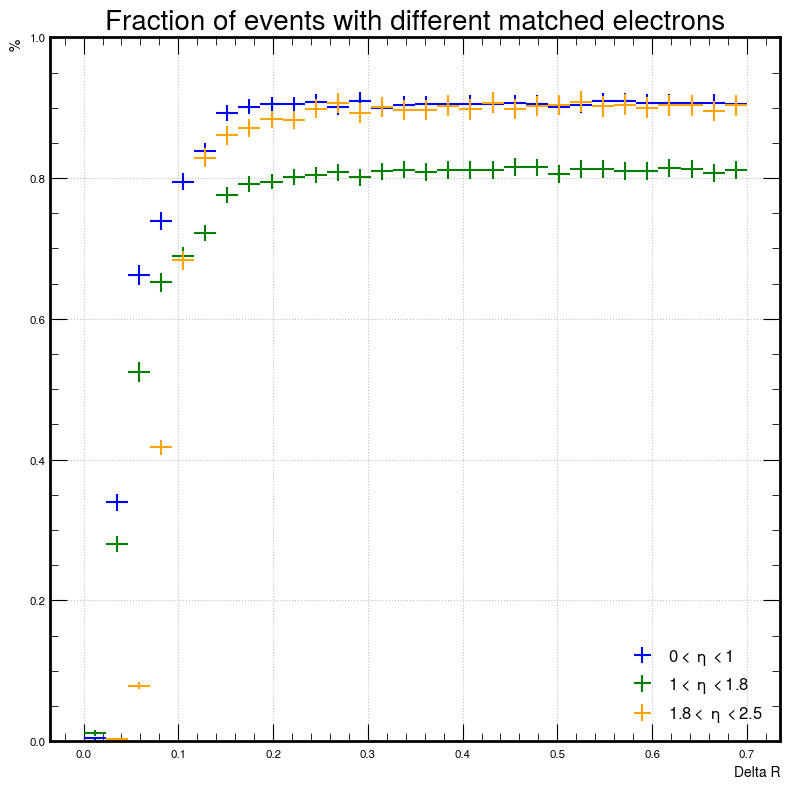

In [143]:
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3

def fraction_different_ele_index_vs_deltaR(num_intervals,different_ele_events):
    deltaR_max = 0.7
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    mask_e1_g = (grouped_deltas.eta_mean<1)&(grouped_deltas.eta_mean>0)
    mask_e3_g =(grouped_deltas.eta_mean<1.8)&(grouped_deltas.eta_mean>1)
    mask_e0_g =(grouped_deltas.eta_mean<2.5)&(grouped_deltas.eta_mean>1.8)
    mask_e1 = (different_ele_events.eta_mean<1)&(different_ele_events.eta_mean>0)
    mask_e3 =(different_ele_events.eta_mean<1.8)&(different_ele_events.eta_mean>1)
    mask_e0 =(different_ele_events.eta_mean<2.5)&(different_ele_events.eta_mean>1.8)
    masks = [(mask_e1,mask_e1_g),
             (mask_e3,mask_e3_g),
             (mask_e0,mask_e0_g)]
    
    names = ['$0< \; \eta \; <1$', '$1< \; \eta \; <1.8$','$1.8< \; \eta \; <2.5$']
    colors= ["blue", "green", "orange"]
    plt.figure(figsize=(8,8), dpi=100)  # Larger figsize
    for (mask_same, mask_all), name, color in zip(masks, names, colors):
        
        fraction_list = []
        yer = []
    
        # mask_en_same = (different_ele_events.energy_ratio > 0.8)&(different_ele_events.energy_ratio > 1.2)
        # mask_en_same2 = (different_ele_events.energy_ratio > 3)
       #for mask_en in [True, mask_en_same, mask_en_same2)
        for i in range(len(deltaR_values) - 1):
            lower_bound = deltaR_values[i]
            upper_bound = deltaR_values[i + 1]
            #print('interval=[',lower_bound,upper_bound,']')
            mask = (different_ele_events['deltaR'] > lower_bound) & (different_ele_events['deltaR'] <= upper_bound) & mask_same
            mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound) & mask_all
            
    
            n1 = len(different_ele_events[mask])
            #print('n1: ',n1)
            ntot = len(grouped_deltas[mask2])
            #print('ntot: ',ntot)
            if ntot == 0:
                ntot = 1
            fraction = n1 / ntot
            fraction_list.append(fraction)
            yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)
    
       
        plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none',
                    label=name, c=color)
        #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('Delta R')
    plt.ylabel('%') 
    plt.ylim(0, 1)
    plt.title('Fraction of events with different matched electrons', fontsize=20)  
    plt.grid(True)
    plt.tight_layout()
   
    plt.legend(loc="lower right",fontsize=12) 
    plt.savefig('plots/different_ele_detlar_eta.png')
    plt.show()

num_intervals = 30
fraction_different_ele_index_vs_deltaR(num_intervals,different_ele_events)


In [96]:
#fraction_vs_deltaR(num_intervals,different_ele_events,'genparticle is ele matched but to a different ele')'

## One matched the other not

In [101]:
#fraction_vs_deltaR(num_intervals,onemissing_events,'One is matched and the other not')

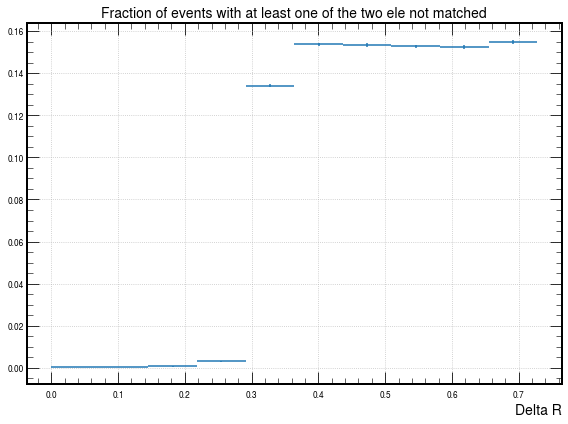

In [82]:
def nonelematched_deltar(num_intervals):
    deltaR_max = onemissing_events['deltaR'].max()
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    fraction_list = []
    yer = []

    for i in range(len(deltaR_values) - 1):
        lower_bound = deltaR_values[i]
        upper_bound = deltaR_values[i + 1]
        mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound)
        dr_group=grouped_deltas[mask2 & onemissing_events_mask]
        
        ntot = len(grouped_deltas[mask2])
        n1 = len(dr_group)
        
        if ntot == 0:
            ntot = 1
        fraction = n1 / ntot
        fraction_list.append(fraction)
        yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)

    plt.figure(figsize=(8,6))  # Larger figsize
    plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none')
    #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('Delta R', fontsize=14)
    plt.title('Fraction of events with at least one of the two ele not matched', fontsize=14) 
    #plt.title('Fraction of events with same ele_index vs. Delta R', fontsize=16)  
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('plots/onemissing_deltaR.png')
    plt.show()

num_intervals = 10
nonelematched_deltar(num_intervals)


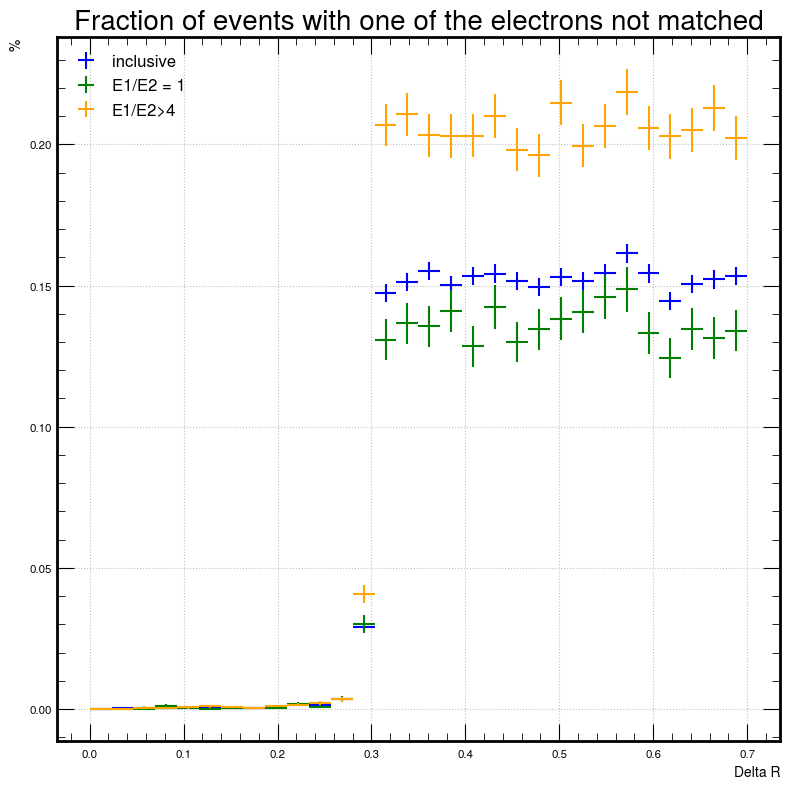

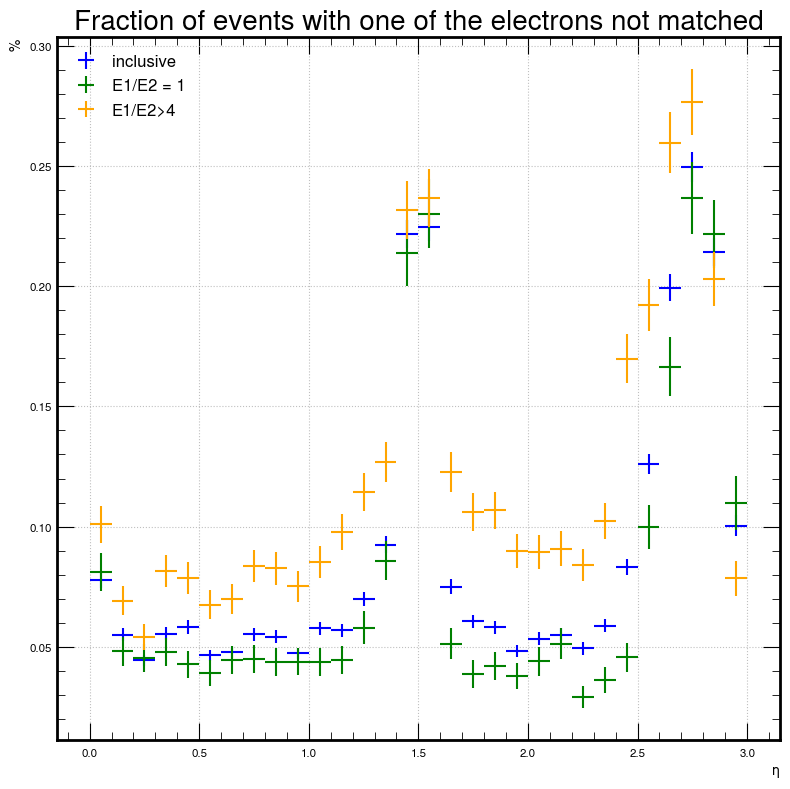

In [35]:
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3

def fraction_onemissing_ele_index_vs_deltaR(num_intervals,deltaR_max,col,xlab):
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    masks = [(1,1), 
             ((onemissing_events.energy_ratio > 0.8)&(onemissing_events.energy_ratio < 1.2),
              (grouped_deltas.energy_ratio > 0.8)&(grouped_deltas.energy_ratio < 1.2)),
             ((onemissing_events.energy_ratio > 4), (grouped_deltas.energy_ratio > 4))]

    names = ["inclusive", "E1/E2 = 1", "E1/E2>4"]
    colors= ["blue", "green", "orange"]
    plt.figure(figsize=(8,8), dpi=100)  # Larger figsize
    for (mask_same, mask_all), name, color in zip(masks, names, colors):
        
        fraction_list = []
        yer = []
    
        # mask_en_same = (onemissing_events.energy_ratio > 0.8)&(onemissing_events.energy_ratio > 1.2)
        # mask_en_same2 = (onemissing_events.energy_ratio > 3)
       #for mask_en in [True, mask_en_same, mask_en_same2)
        for i in range(len(deltaR_values) - 1):
            lower_bound = deltaR_values[i]
            upper_bound = deltaR_values[i + 1]
            #print('interval=[',lower_bound,upper_bound,']')
            mask = (onemissing_events[col] > lower_bound) & (onemissing_events[col] <= upper_bound) & mask_same
            mask2 = (grouped_deltas[col] > lower_bound) & (grouped_deltas[col] <= upper_bound) & mask_all
            
    
            n1 = len(onemissing_events[mask])
            #print('n1: ',n1)
            ntot = len(grouped_deltas[mask2])
            #print('ntot: ',ntot)
            if ntot == 0:
                ntot = 1
            fraction = n1 / ntot
            fraction_list.append(fraction)
            yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)
    
       
        plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none',
                    label=name, c=color)
        #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel(xlab)
    plt.ylabel('%') 
    #plt.ylim(0, 1)
    plt.title('Fraction of events with one of the electrons not matched', fontsize=20)  
    plt.grid(True)
    plt.tight_layout()
    
    plt.legend(loc='upper left',fontsize=12)
    plt.savefig('plots/onemissing_deltaR_E.png')
    plt.show()

num_intervals = 30
fraction_onemissing_ele_index_vs_deltaR(num_intervals, 0.7, 'deltaR', 'Delta R')
fraction_onemissing_ele_index_vs_deltaR(num_intervals, 3, 'eta_mean', '$\eta$')

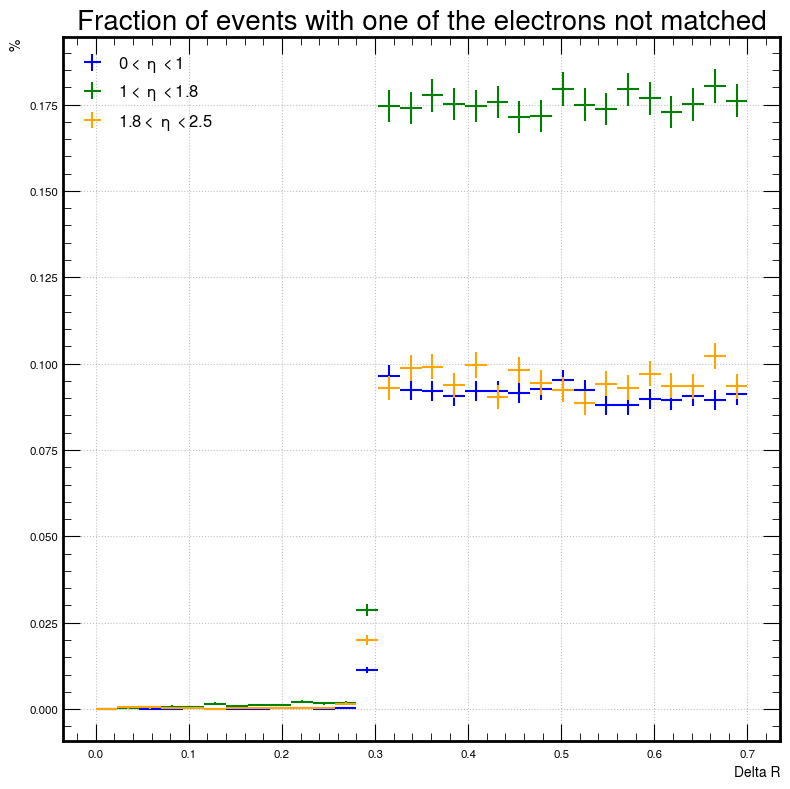

In [145]:
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3

def fraction_onemissing_ele_index_vs_deltaR(num_intervals,different_ele_events):
    deltaR_max = 0.7
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    mask_e1_g = (grouped_deltas.eta_mean<1)&(grouped_deltas.eta_mean>0)
    mask_e3_g =(grouped_deltas.eta_mean<1.8)&(grouped_deltas.eta_mean>1)
    mask_e0_g =(grouped_deltas.eta_mean<2.5)&(grouped_deltas.eta_mean>1.8)
    mask_e1 = (different_ele_events.eta_mean<1)&(different_ele_events.eta_mean>0)
    mask_e3 =(different_ele_events.eta_mean<1.8)&(different_ele_events.eta_mean>1)
    mask_e0 =(different_ele_events.eta_mean<2.5)&(different_ele_events.eta_mean>1.8)
    
    masks = [(mask_e1,mask_e1_g),
             (mask_e3,mask_e3_g),
             (mask_e0,mask_e0_g)]
    
    names = ['$0< \; \eta \; <1$', '$1< \; \eta \; <1.8$','$1.8< \; \eta \; <2.5$']
    colors= ["blue", "green", "orange"]
    plt.figure(figsize=(8,8), dpi=100)  # Larger figsize
    for (mask_same, mask_all), name, color in zip(masks, names, colors):
        
        fraction_list = []
        yer = []
    
        # mask_en_same = (onemissing_events.energy_ratio > 0.8)&(onemissing_events.energy_ratio > 1.2)
        # mask_en_same2 = (onemissing_events.energy_ratio > 3)
       #for mask_en in [True, mask_en_same, mask_en_same2)
        for i in range(len(deltaR_values) - 1):
            lower_bound = deltaR_values[i]
            upper_bound = deltaR_values[i + 1]
            #print('interval=[',lower_bound,upper_bound,']')
            mask = (onemissing_events['deltaR'] > lower_bound) & (onemissing_events['deltaR'] <= upper_bound) & mask_same
            mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound) & mask_all
            
    
            n1 = len(onemissing_events[mask])
            #print('n1: ',n1)
            ntot = len(grouped_deltas[mask2])
            #print('ntot: ',ntot)
            if ntot == 0:
                ntot = 1
            fraction = n1 / ntot
            fraction_list.append(fraction)
            yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)
    
       
        plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none',
                    label=name, c=color)
        #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('Delta R')
    plt.ylabel('%') 
    #plt.ylim(0, 1)
    plt.title('Fraction of events with one of the electrons not matched', fontsize=20)  
    plt.grid(True)
    plt.tight_layout()
    
    plt.legend(loc='upper left',fontsize=12)
    plt.savefig('plots/onemissing_deltaR_eta.png')
    plt.show()

num_intervals = 30
fraction_onemissing_ele_index_vs_deltaR(num_intervals,onemissing_events)


## mask lowest energy

In [37]:
grouped_deltas['calo_energy_min'] = grouped_deltas[['calo_energy1', 'calo_energy2']].min(axis=1)

same_ele_events['calo_energy_min'] = same_ele_events[['calo_energy1', 'calo_energy2']].min(axis=1)
print(same_ele_events[['calo_energy1', 'calo_energy2','calo_energy_min']])

        calo_energy1  calo_energy2  calo_energy_min
11        167.584058     21.289917        21.289917
20        488.966629    164.659506       164.659506
28        360.324382    377.328822       360.324382
31         43.817666      2.659278         2.659278
44        474.800555     24.457067        24.457067
...              ...           ...              ...
482934    224.528736     34.939835        34.939835
482936    482.104056    221.396263       221.396263
482965    424.866953    485.698232       424.866953
482980    345.724521    465.295495       345.724521
482984    466.668523    219.625320       219.625320

[41196 rows x 3 columns]


/tmp/ipykernel_964/2192947528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_ele_events['calo_energy_min'] = same_ele_events[['calo_energy1', 'calo_energy2']].min(axis=1)


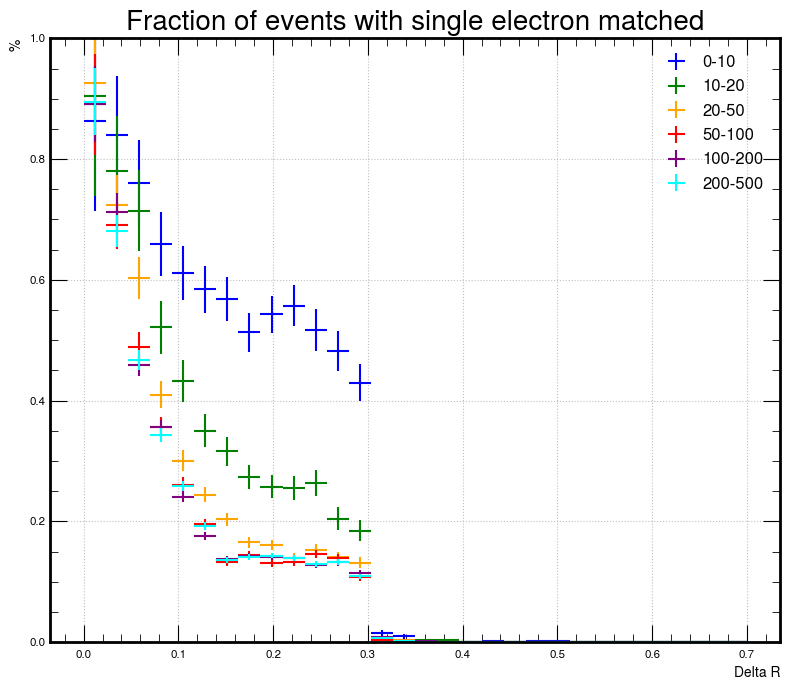

In [38]:
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3

def fraction_same_ele_index_vs_deltaR(num_intervals):
    deltaR_max = 0.7
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    intervals = [(0, 10), (10, 20), (20, 50), (50, 100), (100, 200), (200, 500)]


    masks = []
    for interval in intervals:
        mask_same_ele = (same_ele_events.calo_energy_min > interval[0]) & (same_ele_events.calo_energy_min <= interval[1])
        mask_grouped = (grouped_deltas.calo_energy_min > interval[0]) & (grouped_deltas.calo_energy_min <= interval[1])
        masks.append((mask_same_ele, mask_grouped))

    names = [f"{interval[0]}-{interval[1]}" for interval in intervals]


    colors = ["blue", "green", "orange", "red", "purple", "cyan"]
    plt.figure(figsize=(8,7), dpi=100)  # Larger figsize
    for (mask_same, mask_all), name, color in zip(masks, names, colors):
        
        fraction_list = []
        yer = []
    
        # mask_en_same = (same_ele_events.energy_ratio > 0.8)&(same_ele_events.energy_ratio > 1.2)
        # mask_en_same2 = (same_ele_events.energy_ratio > 3)
       #for mask_en in [True, mask_en_same, mask_en_same2)
        for i in range(len(deltaR_values) - 1):
            lower_bound = deltaR_values[i]
            upper_bound = deltaR_values[i + 1]
            #print('interval=[',lower_bound,upper_bound,']')
            mask = (same_ele_events['deltaR'] > lower_bound) & (same_ele_events['deltaR'] <= upper_bound) & mask_same
            mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound) & mask_all
            
    
            n1 = len(same_ele_events[mask])
            #print('n1: ',n1)
            ntot = len(grouped_deltas[mask2])
            #print('ntot: ',ntot)
            if ntot == 0:
                ntot = 1
            fraction = n1 / ntot
            fraction_list.append(fraction)
            yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)
    
       
        plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none',
                    label=name, c=color)
        #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('Delta R')
    plt.ylabel('%') 
    plt.ylim(0, 1)
    plt.title('Fraction of events with single electron matched', fontsize=20)  
    plt.grid(True)
    plt.tight_layout()
    
    plt.legend(fontsize=12)
    plt.savefig('plots/sameele_deltaR_E.png')
    plt.show()

num_intervals = 30
fraction_same_ele_index_vs_deltaR(num_intervals)


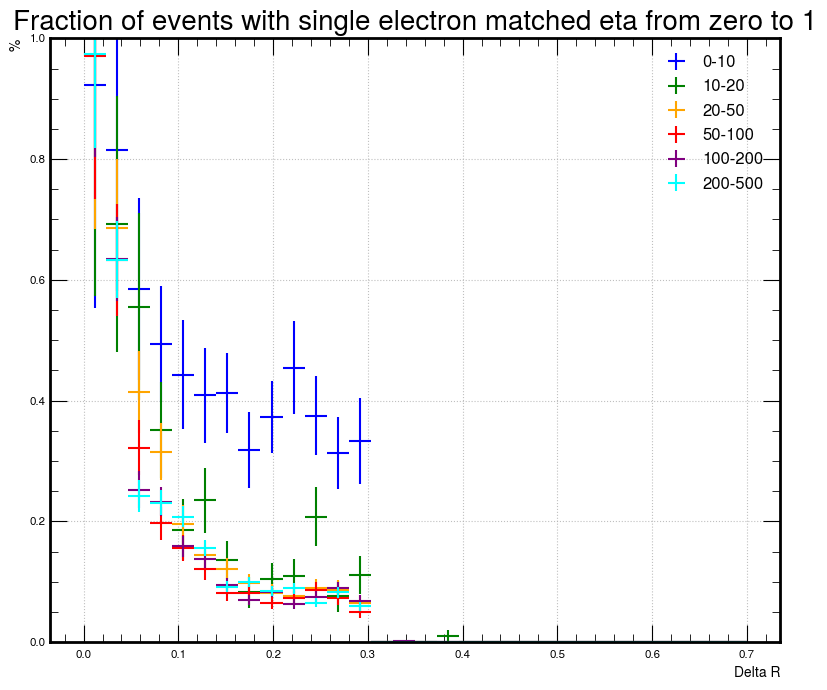

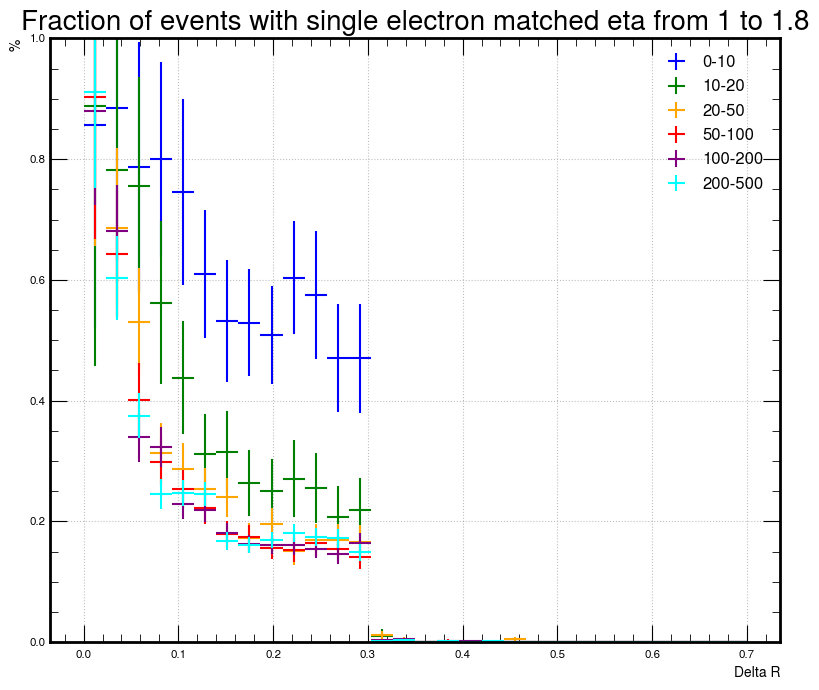

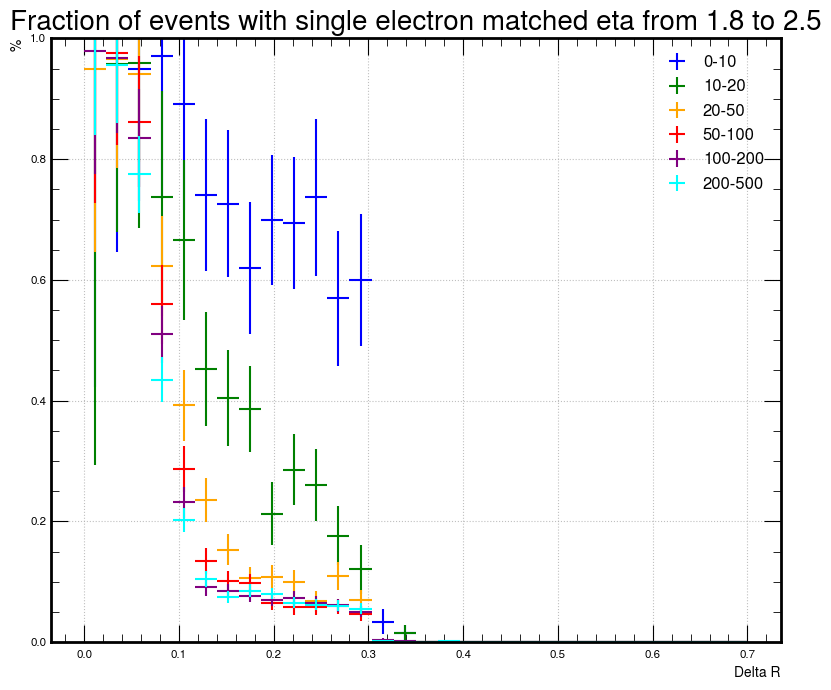

In [39]:
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3

def fraction_same_ele_index_vs_deltaR(num_intervals,same_ele_events,grouped_deltas,tit):
    deltaR_max = 0.7
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    intervals = [(0, 10), (10, 20), (20, 50), (50, 100), (100, 200), (200, 500)]


    masks = []
    for interval in intervals:
        mask_same_ele = (same_ele_events.calo_energy_min > interval[0]) & (same_ele_events.calo_energy_min <= interval[1])
        mask_grouped = (grouped_deltas.calo_energy_min > interval[0]) & (grouped_deltas.calo_energy_min <= interval[1])
        masks.append((mask_same_ele, mask_grouped))

    names = [f"{interval[0]}-{interval[1]}" for interval in intervals]


    colors = ["blue", "green", "orange", "red", "purple", "cyan"]
    plt.figure(figsize=(8,7), dpi=100)  # Larger figsize
    for (mask_same, mask_all), name, color in zip(masks, names, colors):
        
        fraction_list = []
        yer = []
    
        # mask_en_same = (same_ele_events.energy_ratio > 0.8)&(same_ele_events.energy_ratio > 1.2)
        # mask_en_same2 = (same_ele_events.energy_ratio > 3)
       #for mask_en in [True, mask_en_same, mask_en_same2)
        for i in range(len(deltaR_values) - 1):
            lower_bound = deltaR_values[i]
            upper_bound = deltaR_values[i + 1]
            #print('interval=[',lower_bound,upper_bound,']')
            mask = (same_ele_events['deltaR'] > lower_bound) & (same_ele_events['deltaR'] <= upper_bound) & mask_same
            mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound) & mask_all
            
    
            n1 = len(same_ele_events[mask])
            #print('n1: ',n1)
            ntot = len(grouped_deltas[mask2])
            #print('ntot: ',ntot)
            if ntot == 0:
                ntot = 1
            fraction = n1 / ntot
            fraction_list.append(fraction)
            yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)
    
       
        plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none',
                    label=name, c=color)
        #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('Delta R')
    plt.ylabel('%') 
    plt.ylim(0, 1)
    plt.title('Fraction of events with single electron matched '+tit, fontsize=20)  
    plt.grid(True)
    plt.tight_layout()
    
    plt.legend(fontsize=12)
    plt.savefig('plots/sameele_deltaR_E.png')
    plt.show()

    
    
    
    
    
    
mask_e1_g = (grouped_deltas.eta_mean<1)&(grouped_deltas.eta_mean>0)
mask_e3_g =(grouped_deltas.eta_mean<1.8)&(grouped_deltas.eta_mean>1)
mask_e0_g =(grouped_deltas.eta_mean<2.5)&(grouped_deltas.eta_mean>1.8)
mask_e1 = (same_ele_events.eta_mean<1)&(same_ele_events.eta_mean>0)
mask_e3 =(same_ele_events.eta_mean<1.8)&(same_ele_events.eta_mean>1)
mask_e0 =(same_ele_events.eta_mean<2.5)&(same_ele_events.eta_mean>1.8)
num_intervals = 30
fraction_same_ele_index_vs_deltaR(num_intervals,same_ele_events[mask_e1],grouped_deltas[mask_e1_g],'eta from zero to 1')
fraction_same_ele_index_vs_deltaR(num_intervals,same_ele_events[mask_e3],grouped_deltas[mask_e3_g],'eta from 1 to 1.8')
fraction_same_ele_index_vs_deltaR(num_intervals,same_ele_events[mask_e0],grouped_deltas[mask_e0_g],'eta from 1.8 to 2.5')
